In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Conv1D, GlobalMaxPooling1D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from transformers import BertTokenizer, TFBertForSequenceClassification
from tensorflow.keras.optimizers import Adam

In [ ]:
data = pd.read_csv("/content/eda_jobs.csv")
print("Columns in dataset:")
print(list(data.columns))
print(data[['job_title_clean','keywords','country']].head())

Columns in dataset:
['title', 'link', 'published_date', 'is_hourly', 'hourly_low', 'hourly_high', 'budget', 'country', 'job_title_clean', 'keywords', 'year_month', 'year_month_str', 'remote']
                                     job_title_clean  \
0  experienced media buyer for solar pannel and r...   
1                               full stack developer   
2                                    smma bubble app   
3             talent hunter specialized in marketing   
4                                      data engineer   

                                            keywords        country  
0  ['experienced', 'media', 'buyer', 'solar', 'pa...            NaN  
1                     ['full', 'stack', 'developer']  United States  
2                          ['smma', 'bubble', 'app']  United States  
3   ['talent', 'hunter', 'specialized', 'marketing']  United States  
4                               ['data', 'engineer']          India  


In [ ]:
# Use job_title_clean as input text
texts = data['job_title_clean'].astype(str).tolist()

# Define target variable -> e.g., country or remote flag
labels = data['country'].astype(str).tolist()

# Encode labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
num_classes = len(label_encoder.classes_)

print("Target Classes:", label_encoder.classes_)

Target Classes: ['Aland Islands' 'Albania' 'Algeria' 'American Samoa' 'Andorra' 'Angola'
 'Anguilla' 'Antigua and Barbuda' 'Argentina' 'Armenia' 'Aruba'
 'Australia' 'Austria' 'Azerbaijan' 'Bahamas' 'Bahrain' 'Bangladesh'
 'Barbados' 'Belarus' 'Belgium' 'Belize' 'Benin' 'Bermuda' 'Bhutan'
 'Bolivia' 'Bonaire, Sint Eustatius and Saba' 'Bosnia and Herzegovina'
 'Botswana' 'Brazil' 'British Virgin Islands' 'Brunei Darussalam'
 'Bulgaria' 'Burkina Faso' 'Burundi' 'Cambodia' 'Cameroon' 'Canada'
 'Cayman Islands' 'Central African Republic' 'Chad' 'Chile' 'China'
 'Cocos (Keeling) Islands' 'Colombia' 'Comoros' 'Congo'
 'Congo, the Democratic Republic of the' 'Cook Islands' 'Costa Rica'
 'Cote d&#039;Ivoire' 'Croatia' 'Curacao' 'Cyprus' 'Czech Republic'
 'Denmark' 'Djibouti' 'Dominica' 'Dominican Republic' 'Ecuador' 'Egypt'
 'El Salvador' 'Eritrea' 'Estonia' 'Ethiopia' 'Faroe Islands' 'Fiji'
 'Finland' 'France' 'French Guiana' 'French Polynesia' 'Gabon' 'Gambia'
 'Georgia' 'Germany' 'Ghana' 'G

In [ ]:
# ========== 3. TOKENIZATION ==========
max_words = 5000   # vocabulary size
max_len = 20       # max sequence length

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post')

print("Example tokenized sequence:", sequences[0])
print("Example padded sequence:", padded_sequences[0])

Example tokenized sequence: [55, 23, 330, 2, 693, 1, 3, 1628, 967, 453]
Example padded sequence: [  55   23  330    2  693    1    3 1628  967  453    0    0    0    0
    0    0    0    0    0    0]


In [ ]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels_encoded, test_size=0.2, random_state=42)

# ========== 4. LSTM MODEL ==========
model_lstm = Sequential()
model_lstm.add(Embedding(input_dim=max_words, output_dim=64))
model_lstm.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model_lstm.add(Dense(64, activation='relu'))
model_lstm.add(Dropout(0.5))
model_lstm.add(Dense(num_classes, activation='softmax'))

model_lstm.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Build model with input shape to see params
model_lstm.build(input_shape=(None, max_len))
print(model_lstm.summary())


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 20, 64)         │       320,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 213)            │        13,845 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 371,029 (1.42 MB)

 Trainable params: 371,029 (1.42 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
history_lstm = model_lstm.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=32)



Epoch 1/5
6121/6121 ━━━━━━━━━━━━━━━━━━━━ 511s 82ms/step - accuracy: 0.4009 - loss: 2.9858 - val_accuracy: 0.4091 - val_loss: 2.7598
Epoch 2/5
6121/6121 ━━━━━━━━━━━━━━━━━━━━ 547s 80ms/step - accuracy: 0.4109 - loss: 2.7689 - val_accuracy: 0.4169 - val_loss: 2.7146
Epoch 3/5
6121/6121 ━━━━━━━━━━━━━━━━━━━━ 507s 81ms/step - accuracy: 0.4177 - loss: 2.7135 - val_accuracy: 0.4218 - val_loss: 2.6801
Epoch 4/5
6121/6121 ━━━━━━━━━━━━━━━━━━━━ 488s 79ms/step - accuracy: 0.4234 - loss: 2.6578 - val_accuracy: 0.4281 - val_loss: 2.6522
Epoch 5/5
6121/6121 ━━━━━━━━━━━━━━━━━━━━ 504s 79ms/step - accuracy: 0.4278 - loss: 2.6290 - val_accuracy: 0.4323 - val_loss: 2.6440


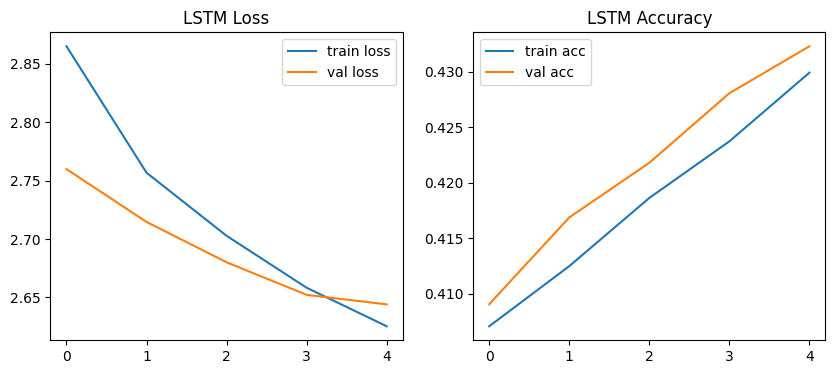

In [ ]:
# Plot training loss/accuracy
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history_lstm.history['loss'], label='train loss')
plt.plot(history_lstm.history['val_loss'], label='val loss')
plt.legend()
plt.title("LSTM Loss")
plt.subplot(1,2,2)
plt.plot(history_lstm.history['accuracy'], label='train acc')
plt.plot(history_lstm.history['val_accuracy'], label='val acc')
plt.legend()
plt.title("LSTM Accuracy")
plt.show()

In [ ]:
model_lstm.save("job_lstm_model.h5")
print(" LSTM model saved as job_lstm_model.h5")

 LSTM model saved as job_lstm_model.h5


In [ ]:
# ========== 5. CNN MODEL ==========
model_cnn = Sequential()
model_cnn.add(Embedding(input_dim=max_words, output_dim=64))   # no need input_length
model_cnn.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model_cnn.add(GlobalMaxPooling1D())
model_cnn.add(Dense(64, activation='relu'))
model_cnn.add(Dropout(0.5))
model_cnn.add(Dense(num_classes, activation='softmax'))

model_cnn.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#  Build model manually so summary shows real params
model_cnn.build(input_shape=(None, max_len))

print(model_cnn.summary())

#  Now fit will work fine
history_cnn = model_cnn.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=5, batch_size=32
)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 20, 64)         │       320,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 16, 128)        │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 213)            │        13,845 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 383,189 (1.46 MB)

 Trainable params: 383,189 (1.46 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/5
6121/6121 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - accuracy: 0.4072 - loss: 2.9551 - val_accuracy: 0.4180 - val_loss: 2.7152
Epoch 2/5
6121/6121 ━━━━━━━━━━━━━━━━━━━━ 36s 3ms/step - accuracy: 0.4170 - loss: 2.7168 - val_accuracy: 0.4239 - val_loss: 2.6757
Epoch 3/5
6121/6121 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.4273 - loss: 2.6279 - val_accuracy: 0.4306 - val_loss: 2.6671
Epoch 4/5
6121/6121 ━━━━━━━━━━━━━━━━━━━━ 40s 4ms/step - accuracy: 0.4333 - loss: 2.5626 - val_accuracy: 0.4321 - val_loss: 2.6798
Epoch 5/5
6121/6121 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.4432 - loss: 2.4778 - val_accuracy: 0.4366 - val_loss: 2.7078


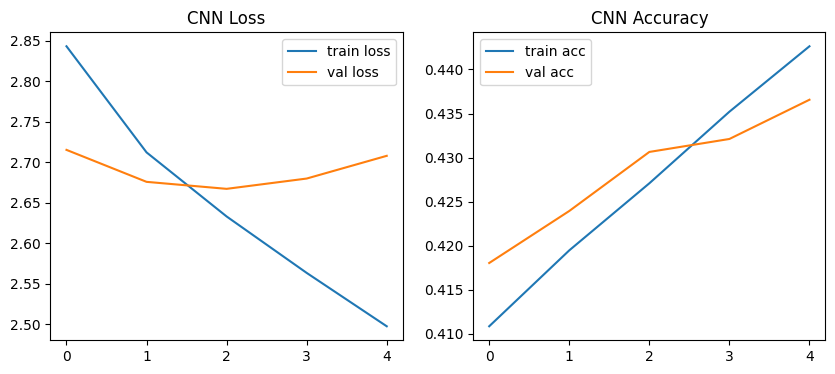

In [ ]:

# Plot CNN results
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history_cnn.history['loss'], label='train loss')
plt.plot(history_cnn.history['val_loss'], label='val loss')
plt.legend()
plt.title("CNN Loss")

plt.subplot(1,2,2)
plt.plot(history_cnn.history['accuracy'], label='train acc')
plt.plot(history_cnn.history['val_accuracy'], label='val acc')
plt.legend()
plt.title("CNN Accuracy")
plt.show()

In [ ]:
# Save
model_cnn.save("job_cnn_model.h5")
print("CNN model saved as job_cnn_model.h5")

CNN model saved as job_cnn_model.h5


In [ ]:
!pip install transformers datasets -q

In [ ]:
texts = data['job_title_clean'].astype(str).tolist()
labels = data['country'].astype(str).tolist()

# Encode labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
num_classes = len(label_encoder.classes_)
print("Classes:", label_encoder.classes_)


Classes: ['Aland Islands' 'Albania' 'Algeria' 'American Samoa' 'Andorra' 'Angola'
 'Anguilla' 'Antigua and Barbuda' 'Argentina' 'Armenia' 'Aruba'
 'Australia' 'Austria' 'Azerbaijan' 'Bahamas' 'Bahrain' 'Bangladesh'
 'Barbados' 'Belarus' 'Belgium' 'Belize' 'Benin' 'Bermuda' 'Bhutan'
 'Bolivia' 'Bonaire, Sint Eustatius and Saba' 'Bosnia and Herzegovina'
 'Botswana' 'Brazil' 'British Virgin Islands' 'Brunei Darussalam'
 'Bulgaria' 'Burkina Faso' 'Burundi' 'Cambodia' 'Cameroon' 'Canada'
 'Cayman Islands' 'Central African Republic' 'Chad' 'Chile' 'China'
 'Cocos (Keeling) Islands' 'Colombia' 'Comoros' 'Congo'
 'Congo, the Democratic Republic of the' 'Cook Islands' 'Costa Rica'
 'Cote d&#039;Ivoire' 'Croatia' 'Curacao' 'Cyprus' 'Czech Republic'
 'Denmark' 'Djibouti' 'Dominica' 'Dominican Republic' 'Ecuador' 'Egypt'
 'El Salvador' 'Eritrea' 'Estonia' 'Ethiopia' 'Faroe Islands' 'Fiji'
 'Finland' 'France' 'French Guiana' 'French Polynesia' 'Gabon' 'Gambia'
 'Georgia' 'Germany' 'Ghana' 'Gibralta

In [ ]:
# Tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
encodings = tokenizer(texts, truncation=True, padding=True, max_length=32, return_tensors="tf")

# Convert tensors to NumPy arrays
input_ids = encodings['input_ids'].numpy()
attention_mask = encodings['attention_mask'].numpy()


X_train_ids, X_test_ids, X_train_mask, X_test_mask, y_train, y_test = train_test_split(
    input_ids, attention_mask, labels_encoded, test_size=0.2, random_state=42
)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.


In [ ]:
# Train-test split
X_train_ids, X_test_ids, y_train, y_test = train_test_split(
    input_ids, labels_encoded, test_size=0.2, random_state=42
)

X_train_mask, X_test_mask, _, _ = train_test_split(
    attention_mask, labels_encoded, test_size=0.2, random_state=42
)

In [ ]:
# Rebuild inputs
train_inputs = {'input_ids': X_train_ids, 'attention_mask': X_train_mask}
test_inputs  = {'input_ids': X_test_ids, 'attention_mask': X_test_mask}

In [ ]:
# ========== 3. Define BERT Model ==========
model_bert = TFBertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=num_classes,
    use_safetensors=False
)

optimizer = Adam(learning_rate=5e-5)
model_bert.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

# Create input dictionaries for training and testing
train_inputs = {'input_ids': X_train_ids, 'attention_mask': X_train_mask}
test_inputs  = {'input_ids': X_test_ids, 'attention_mask': X_test_mask}

model_bert.summary()

tf_model.h5:   0%|          | 0.00/536M [00:00<?, ?B/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0 (unused)
                                                                 
 classifier (Dense)          multiple                  163797    
                                                                 
Total params: 109646037 (418.27 MB)
Trainable params: 109646037 (418.27 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# ========== 4. Train ==========
history_bert = model_bert.fit(
    train_inputs, y_train,
    validation_data=(test_inputs, y_test),
    epochs=2,
    batch_size=16

)





Epoch 1/2
12242/12242 [==============================] - 1779s 141ms/step - loss: 2.8907 - accuracy: 0.4073 - val_loss: 2.8636 - val_accuracy: 0.4076
Epoch 2/2
12242/12242 [==============================] - 1705s 139ms/step - loss: 2.8576 - accuracy: 0.4078 - val_loss: 2.8558 - val_accuracy: 0.4076


In [ ]:
# ==========  Evaluate=======
loss, acc = model_bert.evaluate(test_inputs, y_test)
print(f"BERT Test Accuracy: {acc:.4f}")


  65/1531 [>.............................] - ETA: 2:00 - loss: 2.8526 - accuracy: 0.4149

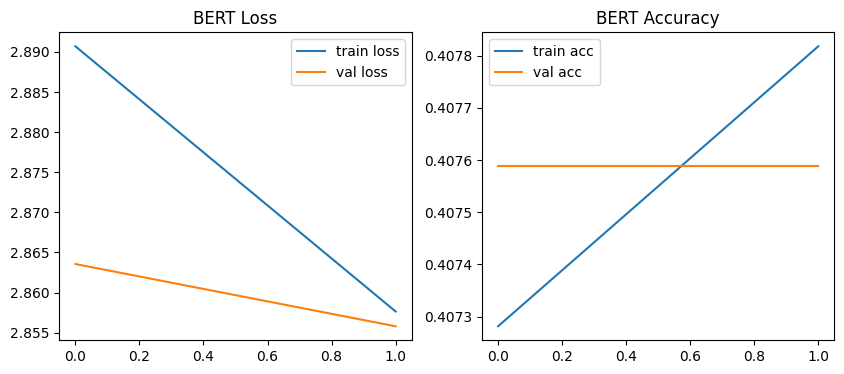

In [ ]:
# ==========  Plot Training Curves ==========
plt.figure(figsize=(10,4))

# Loss
plt.subplot(1,2,1)
plt.plot(history_bert.history['loss'], label='train loss')
plt.plot(history_bert.history['val_loss'], label='val loss')
plt.legend()
plt.title("BERT Loss")

# Accuracy
plt.subplot(1,2,2)
plt.plot(history_bert.history['accuracy'], label='train acc')
plt.plot(history_bert.history['val_accuracy'], label='val acc')
plt.legend()
plt.title("BERT Accuracy")

plt.show()

In [ ]:
# Save
model_bert.save_pretrained("job_bert_model")
tokenizer.save_pretrained("job_bert_model")
print(" BERT model + tokenizer saved in job_bert_model/")